# Импорт необходимыз модулей

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


print('Succesfull!')

Succesfull!


# Подготовка необходимого датасета

In [3]:
# from tensorflow.python.ops.gen_data_flow_ops import ordered_map_incomplete_size
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


In [4]:
image_count = len(list(dataset_dir.glob('*/*.jpg')))
print('Number of images is ' + str(image_count))

Number of images is 3670


In [5]:
batch_size = 32
img_width = 180
img_height = 180


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print('Class names: ' + str(class_names))

Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Элементы датасета необходимо закэшировать перед обучением по рекомендации tensorflow.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Создание модели

In [18]:
num_classes = len(class_names)
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)]
)

# Компиляция модели

In [14]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Вывод модели

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)        1

# Обучаем модель

In [16]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 127s 1s/step - loss: 1.5328 - accuracy: 0.3420 - val_loss: 1.2695 - val_accuracy: 0.4591
Epoch 2/10
92/92 [==============================] - 108s 1s/step - loss: 1.1132 - accuracy: 0.5436 - val_loss: 1.1026 - val_accuracy: 0.5599
Epoch 3/10
92/92 [==============================] - 104s 1s/step - loss: 0.9271 - accuracy: 0.6492 - val_loss: 1.0084 - val_accuracy: 0.5954
Epoch 4/10
92/92 [==============================] - 105s 1s/step - loss: 0.7458 - accuracy: 0.7190 - val_loss: 1.0678 - val_accuracy: 0.6076
Epoch 5/10
92/92 [==============================] - 105s 1s/step - loss: 0.5532 - accuracy: 0.7997 - val_loss: 1.0843 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 100s 1s/step - loss: 0.3771 - accuracy: 0.8692 - val_loss: 1.2555 - val_accuracy: 0.6104
Epoch 7/10
92/92 [==============================] - 101s 1s/step - loss: 0.2164 - accuracy: 0.9319 - val_loss: 1.3389 - val_accuracy: 0.6390
Epoch 8/10
92

Ниже представлена визуализация результатов.

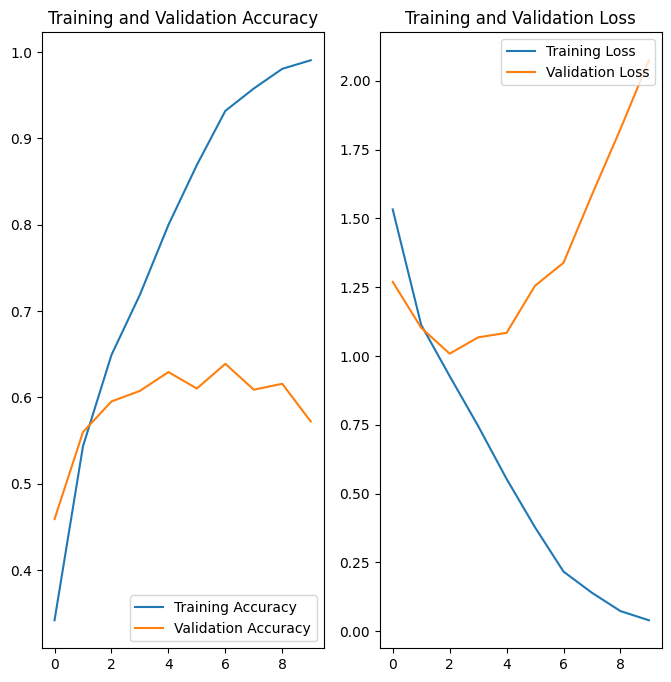

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Добавим аугментацию, чтобы улучшить точность ИНС.

In [22]:
num_classes = len(class_names)
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.2),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # regularisation
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)]
)

Снова компилируем.

In [24]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Снова обучаем модель.

In [25]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 128s 1s/step - loss: 1.3842 - accuracy: 0.4077 - val_loss: 1.1299 - val_accuracy: 0.5395
Epoch 2/10
92/92 [==============================] - 118s 1s/step - loss: 1.0647 - accuracy: 0.5695 - val_loss: 1.2738 - val_accuracy: 0.5327
Epoch 3/10
92/92 [==============================] - 118s 1s/step - loss: 0.9878 - accuracy: 0.6059 - val_loss: 0.9544 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 119s 1s/step - loss: 0.8977 - accuracy: 0.6413 - val_loss: 0.8561 - val_accuracy: 0.6608
Epoch 5/10
92/92 [==============================] - 119s 1s/step - loss: 0.8356 - accuracy: 0.6655 - val_loss: 0.8430 - val_accuracy: 0.6730
Epoch 6/10
92/92 [==============================] - 120s 1s/step - loss: 0.7801 - accuracy: 0.7030 - val_loss: 0.8071 - val_accuracy: 0.6853
Epoch 7/10
92/92 [==============================] - 120s 1s/step - loss: 0.7583 - accuracy: 0.7057 - val_loss: 0.7966 - val_accuracy: 0.6839
Epoch 8/10
92

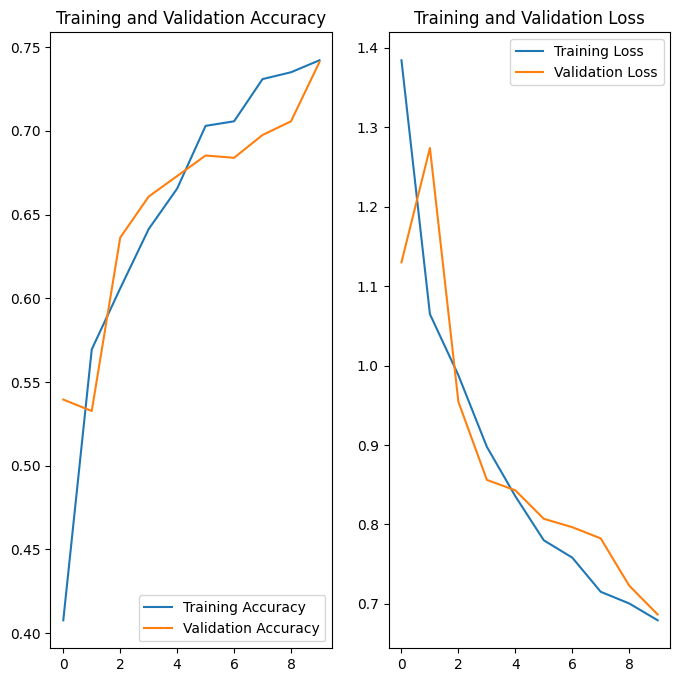

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Сохраним весы.

In [27]:
model.save_weights('my_flowers_model')
print('Model saved!')

Model saved!


Подгружаем новую картинку!

In [28]:
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path,
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)


117948/117948 [==============================] - 0s 0us/step


Делаем предсказание!

In [33]:
pred = model.predict(img_array)
score = tf.nn.softmax(pred[0])

1/1 [==============================] - 0s 50ms/step


Предоставляем результат!

In [34]:
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

img.show()

На изображении скорее всего sunflowers (96.81% вероятность)
